# Ozon coding interview

## Постановка задачи

Интервьюером была предложена следующая задача:

Написать функцию, которая на вход принимает 2 аргумента - массив чисел(lst) и заданное число(target), - и выводит индексы **2 элементов**, сумма которых равна заданному числу.

Пример:
```
Input: nums = [15, 2, 7, 11, 8], target = 9
Output: [1, 2]
```

После постановки задачи было проговорено, что решение гарантированно существует и оно единственно. Все варианты алгоритмов ниже сильно полагаются на этот факт и не выполняют никаких проверок. В изначальном варианте слова  "2 элемента", выделенные  жирным,  были пропущены. После того, как я написал довольно много кода для решения задачи с произвольным количеством элементов, интервьюер заметил, что я закопался и добавил уточнение про два элемента.

## Алгоритмы решения

In [73]:
from timeit import timeit
from random import shuffle
import pandas as pd
import datetime
import numpy as np
pd.set_option('precision', 3)

Мной был предложен очевидный наивный алгоритм с двумя проходами по массиву и сложностью O(N^2)- функция `indexes_naive`.

In [62]:
def indexes_naive(lst, target):      
    for item_i, item1 in enumerate(lst):
        for item_j, item2 in enumerate(lst):
            if item_i != item_j and item1 + item2 == target:
                return [item_i, item_j]

Мой собеседник предложил найти однопроходный вариант. За оставшееся время ничего толкового в голову не пришло. Интервьюер в качестве "однопроходного" решения написал код ниже - функция `indexes_in`:

In [11]:
def indexes_in (lst, target):
	for i, val in enumerate(lst):
		if (target - val) in lst and i != lst.index(target - val):
			return [i, lst.index(target - val)]

Данное решение дает существенный выигрыш в производительности по сравнению с наивным решением за счет того, что внутренний цикл теперь выполняется на `C`. Однако асимптотика у него остается точно такая же - O(N^2). С моей точки зрения, это нельзя назвать однопроходным вариантом, так как внутренний цикл все равно остается, хоть и замаскированный. Про асимптотическую сложность `in` для списков можно прочесть здесь: https://wiki.python.org/moin/TimeComplexity.
Для убедительности приведу исходный код (https://github.com/python/cpython/blob/main/Objects/listobject.c#L431) на C для `in`. Видно, что мы так же пробегаем по списку, как и в Питоне :

```c
static int
list_contains(PyListObject *a, PyObject *el)
{
    PyObject *item;
    Py_ssize_t i;
    int cmp;

    for (i = 0, cmp = 0 ; cmp == 0 && i < Py_SIZE(a); ++i) {
        item = PyList_GET_ITEM(a, i);
        Py_INCREF(item);
        cmp = PyObject_RichCompareBool(item, el, Py_EQ);
        Py_DECREF(item);
    }
    return cmp;
}
```

Далее интервьюер сказал, что существует хорошее решение O(N*log(N)) - надо предварительно отсортировать список и дальше идти с обоих концов. На этом интервью закончилось.

Алгоритм с сортировкой приведен ниже - функция `indexes_sort`:

In [15]:
def indexes_sort(lst, target):
    sorted_lst, old_index = zip(*sorted(zip(lst, range(len(lst)))))
    finger1, finger2 = 0, len(sorted_lst)-1
    while finger1 != finger2:
        cur_sum = sorted_lst[finger1] + sorted_lst[finger2]
        if cur_sum < target:
            finger1 += 1
        elif cur_sum > target:
            finger2 -= 1
        else:
            return [old_index[finger1], old_index[finger2]] 

В процессе "работы надо ошибками" я нашел на просторах интернета, что возможно решение с асимптотикой O(N). Мы создаем словарь, где ключи - это элементы списка, а значения - это номер элемента. Потом перебираем массив и находим в словаре комплиментарное значение. Так как поиск по ключу в словаре O(1), то получаем то самое однопроходное решение - функция `indexes_fast`:

In [63]:
def indexes_fast(lst, target):
    # если у нас два одинаковых числа образуют сумму, то словарь попадет индекс последнего
    # из-за этого мы не выведем два одинаковых индекса
    lst_dict = dict(zip(lst, range(len(lst))))
    for index_i, item_i in enumerate(lst):
        if target - item_i in lst_dict: 
            return [index_i, lst_dict[target - item_i]]

Небольшая проверка, что все алгоритмы дают один и тот же результат:

In [65]:
nums = [15, 2, 7, 11, 8]
target = 9
print(indexes_naive(nums, target))
print(indexes_in(nums, target))
print(indexes_sort(nums, target))
print(indexes_fast(nums, target))

[1, 2]
[1, 2]
[1, 2]
[1, 2]


In [66]:
nums = [0, 0, 4, 4, 0, 0]
target = 8
print(indexes_naive(nums, target))
print(indexes_in(nums, target))
print(indexes_sort(nums, target))
print(indexes_fast(nums, target))

[2, 3]
[3, 2]
[2, 3]
[2, 3]


## Бенчмарки

Самая интересная часть - потестируем все алгоритмы на производительность

In [67]:
max_power = 20 # максимальная длина списка (2^max_power), с которым будем мерять производительность
max_n2 = 12    # максимальная длина списка для алгоритмов с O(N^2). Иначе просто не дождемся результатов.
 
# словарь, ключ - длина списка без двух элементов, значение - список таймингами
timings = {}
funs = [lambda: indexes_naive(curr, target), 
        lambda: indexes_in(curr, target), 
        lambda: indexes_sort(curr, target),
        lambda: indexes_fast(curr, target)
        ]
for i in range(2, max_power):
    timings[i] = [0]*len(funs)
    
# Мы будем использовать значения 2 и 7, а остальные - нули

repeats = 10 # сколько перестановок делать
local_repeats = 5 # количество повторений с одинаковым списком

for n in timings:
	print(datetime.datetime.now(), ": n =", n)
	curr = [2, 7] + [0]*(2**n)
	for _ in range(100):
		shuffle(curr)
		# print(curr)
		for i,_ in enumerate(funs):
			if n > max_n2 and i<2: continue
			timings[n][i] += timeit(funs[i], number = local_repeats)
			
		for i,_ in enumerate(funs):
			timings[n][i] /= local_repeats*repeats

# timings

2021-12-20 00:57:17.966076 : n = 2
2021-12-20 00:57:18.007365 : n = 3
2021-12-20 00:57:18.051677 : n = 4
2021-12-20 00:57:18.106403 : n = 5
2021-12-20 00:57:18.201573 : n = 6
2021-12-20 00:57:18.460450 : n = 7
2021-12-20 00:57:19.255811 : n = 8
2021-12-20 00:57:22.254868 : n = 9
2021-12-20 00:57:33.862691 : n = 10
2021-12-20 00:58:23.776007 : n = 11
2021-12-20 01:01:42.762733 : n = 12
2021-12-20 01:15:14.889562 : n = 13
2021-12-20 01:15:16.845805 : n = 14
2021-12-20 01:15:20.867599 : n = 15
2021-12-20 01:15:29.281980 : n = 16
2021-12-20 01:15:48.213353 : n = 17
2021-12-20 01:16:27.360763 : n = 18
2021-12-20 01:17:46.257338 : n = 19


Для дальнейшего анализа конвертируем результаты в DataFrame. Выведем сами тайминги и их отношение к таймингу самого быстрого алгоритма.

In [97]:
res = pd.DataFrame(timings).transpose().reset_index()
res.columns = ['n', 'indexes_naive', 'indexes_in', 'indexes_sort', 'indexes_fast']
res['n_elem'] = 2**res['n']
res = res[['n', 'n_elem', 'indexes_naive', 'indexes_in', 'indexes_sort', 'indexes_fast']]
for column in ['indexes_naive', 'indexes_in', 'indexes_sort', 'indexes_fast']:
    res.loc[res[column] == 0, column] = np.nan
    res["ratio_" + column] = res[column]/res['indexes_fast']
    
res

,n,n_elem,indexes_naive,indexes_in,indexes_sort,indexes_fast,ratio_indexes_naive,ratio_indexes_in,ratio_indexes_sort,ratio_indexes_fast
0,2,4,4.667e-07,1.520e-07,3.668e-07,2.761e-07,1.690,0.551,1.328,1.0
1,3,8,1.017e-06,2.389e-07,4.787e-07,2.615e-07,3.887,0.913,1.830,1.0
2,4,16,3.115e-06,5.366e-07,7.588e-07,3.409e-07,9.135,1.574,2.226,1.0
3,5,32,1.358e-05,2.449e-06,2.068e-06,8.103e-07,16.758,3.023,2.552,1.0
4,6,64,3.310e-05,5.221e-06,2.102e-06,7.997e-07,41.389,6.529,2.628,1.0
5,7,128,1.267e-04,1.874e-05,3.527e-06,1.437e-06,88.174,13.043,2.455,1.0
6,8,256,5.368e-04,7.187e-05,7.024e-06,2.790e-06,192.452,25.763,2.518,1.0
7,9,512,1.972e-03,2.506e-04,1.260e-05,5.061e-06,389.556,49.519,2.490,1.0
8,10,1024,9.112e-03,1.110e-03,2.828e-05,1.213e-05,751.227,91.553,2.332,1.0
9,11,2048,3.565e-02,4.210e-03,5.251e-05,2.227e-05,1600.557,189.042,2.358,1.0


По цифрам видно, как все прочие алгоритмы отстают от алгоритма со словарем c ростом `n`. Отобразим это графически:

<AxesSubplot:xlabel='n_elem'>

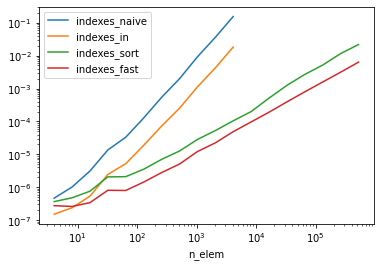

In [99]:
res.plot(x = "n_elem", y = ["indexes_naive", "indexes_in", "indexes_sort", "indexes_fast"], loglog = True)


На графике не очень заметно, что отставание алгоритма с сортировкой от алгоритма со словарем все больше увеличивается с ростом размера списка. Разделим каждый тайминг на его предполагаемую асимптотику - должна получится константа и графики в какой-то момент выйдут на горизонтальную линию.

<AxesSubplot:xlabel='n_elem'>

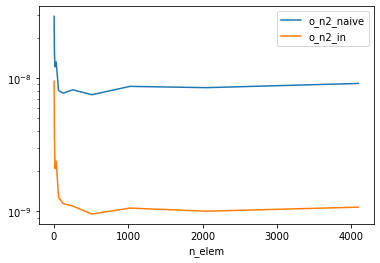

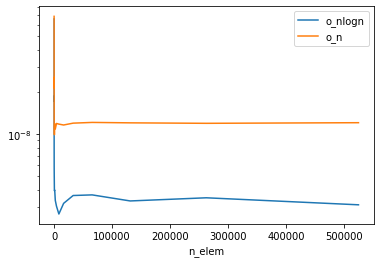

In [111]:
res["o_n2_naive"] = res['indexes_naive']/res['n_elem']/res['n_elem']
res["o_n2_in"] = res['indexes_in']/res['n_elem']/res['n_elem']
res["o_nlogn"] = res['indexes_sort']/res['n_elem']/np.log(res['n_elem'])
res["o_n"] = res['indexes_fast']/res['n_elem']
res.plot(x = "n_elem", y = ["o_n2_naive", "o_n2_in"], logy = True)
res.plot(x = "n_elem", y = ["o_nlogn", "o_n"], logy = True)

Практика совпала с теорией. 

## Выводы

В принципе, простая задача, однако на ней можно узнать интересные вещи и про алгоритмы, и про внутреннее устройство Питона.